# Разделение (биннинг, дискретизация, балансировка) данных с помощью qcut и cut в Pandas

<a href="https://colab.research.google.com/github/dm-fedorov/pandas_basic/blob/master/%D0%A2%D0%B5%D0%BF%D0%BB%D0%B8%D1%86%D0%B0/5.%20%D0%9F%D0%B0%D1%80%D0%BA%D0%B8.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory" target="_blank"></a>

## Введение

При работе с непрерывными числовыми данными часто бывает полезно *разделить* (to bin) данные на несколько сегментов для дальнейшего анализа. Существует несколько терминов: сегментирование (`bucketing`), дискретное разделение (`discrete binning`), дискретизация (`discretization`) или квантование (`quantization`). Pandas поддерживает эти подходы с помощью функций [`cut`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html) и [`qcut`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html). 

В этой статье говорится о том, как использовать функции pandas для преобразования непрерывных данных в набор дискретных сегментов. Как и многие функции pandas, `cut` и `qcut` могут показаться простыми, но у них есть множество возможностей. Думаю, даже опытные пользователи научатся нескольким приемам, которые будут полезны для анализа.

> Оригинал статьи Криса [тут](https://pbpython.com/pandas-qcut-cut.html)

## Биннинг (binning)

Один из наиболее распространенных случаев *биннинга* выполняется при создании гистограммы. 

Рассмотрим пример с продажами. Гистограмма данных о продажах показывает, как непрерывный набор показателей продаж можно разделить на дискретные ячейки (например: `60 000`–`70 000` долларов США), а затем использовать их для группировки и подсчета учетных записей (`account number`).

In [1]:
# импортируем необходимые модули:
import pandas as pd
import numpy as np
import seaborn as sns

# добавляем в графики красивости seaborn:
sns.set_style('whitegrid') 

In [2]:
raw_df = pd.read_excel('https://github.com/chris1610/pbpython/blob/master/data/2018_Sales_Total_v2.xlsx?raw=true')
raw_df.head()

,account number,name,sku,quantity,unit price,ext price,date
0,740150,Barton LLC,B1-20000,39,86.69,3380.91,2018-01-01 07:21:51.000002
1,714466,Trantow-Barrows,S2-77896,-1,63.16,-63.16,2018-01-01 10:00:47.000004
2,218895,Kulas Inc,B1-69924,23,90.70,2086.10,2018-01-01 13:24:57.999997
3,307599,"Kassulke, Ondricka and Metz",S1-65481,41,21.05,863.05,2018-01-01 15:05:21.999995
4,412290,Jerde-Hilpert,S2-34077,6,83.21,499.26,2018-01-01 23:26:55.000003


Далее представлен код, который показывает, как суммировать информацию о продажах за 2018 год для группы клиентов. Это представление отображает количество клиентов, у которых продажи находятся в определенных диапазонах:

In [3]:
df = raw_df.groupby(['account number', 'name'])['ext price'].sum().reset_index()
df.head()

,account number,name,ext price
0,141962,Herman LLC,63626.03
1,146832,Kiehn-Spinka,99608.77
2,163416,Purdy-Kunde,77898.21
3,218895,Kulas Inc,137351.96
4,239344,Stokes LLC,91535.92


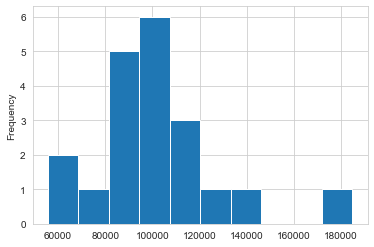

In [4]:
df['ext price'].plot(kind='hist');

Существует множество других сценариев, в которых вы можете определить собственные интервалы (*bins*). 

В приведенном выше примере `8` интервалов с данными. Что, если бы мы захотели разделить наших клиентов на `3`, `4` или `5` групп? 

Вот где в игру вступают `qcut` и `cut`. Эти функции кажутся похожими и выполняют аналогичные функции группирования, но имеют различия, которые могут сбивать с толку новых пользователей.  

Остальная часть статьи покажет, в чем их различия и как их использовать.

### qcut

В [документации `qcut`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html) описывается как *"функция дискретизации на основе квантилей"*. По сути, это означает, что `qcut` пытается разделить базовые данные на интервалы равного размера. Функция определяет интервалы с использованием процентилей на основе распределения данных, а не фактических числовых границ интервалов.

Если вы ранее использовали функцию `description`, то уже встречали пример основных концепций, представленных `qcut`:

In [5]:
df['ext price'].describe()

count        20.000000
mean     101711.287500
std       27037.449673
min       55733.050000
25%       89137.707500
50%      100271.535000
75%      110132.552500
max      184793.700000
Name: ext price, dtype: float64

Запомните значения для `25%`, `50%` и `75%` процентилей, поскольку мы напрямую рассматрим использование `qcut`.

Самое простое использование `qcut` - определить количество квантилей и позволить pandas разделить данные. 

В приведенном ниже примере мы просим pandas создать `4` группы одинакового размера:

In [6]:
pd.qcut(df['ext price'], q=4)

0     (55733.049000000006, 89137.708]
1             (89137.708, 100271.535]
2     (55733.049000000006, 89137.708]
3              (110132.552, 184793.7]
4             (89137.708, 100271.535]
5             (89137.708, 100271.535]
6     (55733.049000000006, 89137.708]
7            (100271.535, 110132.552]
8              (110132.552, 184793.7]
9              (110132.552, 184793.7]
10            (89137.708, 100271.535]
11    (55733.049000000006, 89137.708]
12    (55733.049000000006, 89137.708]
13            (89137.708, 100271.535]
14           (100271.535, 110132.552]
15             (110132.552, 184793.7]
16           (100271.535, 110132.552]
17             (110132.552, 184793.7]
18           (100271.535, 110132.552]
19           (100271.535, 110132.552]
Name: ext price, dtype: category
Categories (4, interval[float64]): [(55733.049000000006, 89137.708] < (89137.708, 100271.535] < (100271.535, 110132.552] < (110132.552, 184793.7]]

В результате получается *категориальный ряд* (про категориальный тип данных в pandas см. [тут](http://dfedorov.spb.ru/pandas/%D0%98%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5%20%D1%82%D0%B8%D0%BF%D0%B0%20%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85%20%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B8%20%D0%B2%20pandas.html)), представляющий интервалы с продажами. Поскольку мы запросили квантили с `q=4`, поэтому интервалы соответствуют процентилям из функции `describe`.

Типичным вариантом использования является сохранение результатов разбиения в исходном фрейме данных (`dataframe`) для будущего анализа. 

В следующем примере мы создадим `4` интервала (также называемых *квартилями*) и `10` интервалов (также называемых *децилями*) и сохраним результаты обратно в исходный фрейм данных:

In [7]:
df['quantile_ex_1'] = pd.qcut(df['ext price'], q=4)
df['quantile_ex_2'] = pd.qcut(df['ext price'], q=10, precision=0)

df.head()

,account number,name,ext price,quantile_ex_1,quantile_ex_2
0,141962,Herman LLC,63626.03,"(55733.049000000006, 89137.708]","(55732.0, 76471.0]"
1,146832,Kiehn-Spinka,99608.77,"(89137.708, 100271.535]","(95908.0, 100272.0]"
2,163416,Purdy-Kunde,77898.21,"(55733.049000000006, 89137.708]","(76471.0, 87168.0]"
3,218895,Kulas Inc,137351.96,"(110132.552, 184793.7]","(124778.0, 184794.0]"
4,239344,Stokes LLC,91535.92,"(89137.708, 100271.535]","(90686.0, 95908.0]"


Обратите внимание, как сильно различаются интервалы между `quantile_ex_1` и `quantile_ex_2`. Я также добавил `precision` (точности), чтобы определить, сколько десятичных знаков использовать для вычисления точности интервала.

Можем посмотреть, как значения распределяются по интервалам с помощью `value_counts`:

In [8]:
df['quantile_ex_1'].value_counts()

(55733.049000000006, 89137.708]    5
(89137.708, 100271.535]            5
(100271.535, 110132.552]           5
(110132.552, 184793.7]             5
Name: quantile_ex_1, dtype: int64

Теперь для второго столбца:

In [9]:
df['quantile_ex_2'].value_counts()

(55732.0, 76471.0]      2
(76471.0, 87168.0]      2
(87168.0, 90686.0]      2
(90686.0, 95908.0]      2
(95908.0, 100272.0]     2
(100272.0, 103606.0]    2
(103606.0, 105938.0]    2
(105938.0, 112290.0]    2
(112290.0, 124778.0]    2
(124778.0, 184794.0]    2
Name: quantile_ex_2, dtype: int64

> Это иллюстрирует ключевую концепцию: в каждом случае в каждом интервале содержится равное количество наблюдений. 

Pandas за кулисами производит вычисления, чтобы определить ширину интервалов. Например, в `quantile_ex_1` диапазон первого интервала составляет `74661.15`, а второго - `9861.02` (`110132` - `100271`).

Одна из проблем, связанных с этим подходом, заключается в том, что имена интервалов сложно объяснить конечному пользователю. 

Например, если мы хотим разделить наших клиентов на `5` групп (также называемых *квинтилями*), как в случае с часто летающими авиакомпаниями, мы можем явно назвать интервалы, чтобы их было легче интерпретировать:

In [10]:
bin_labels_5 = ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond']

df['quantile_ex_3'] = pd.qcut(df['ext price'],
                              q=[0, .2, .4, .6, .8, 1],
                              labels=bin_labels_5)
df.head()

,account number,name,ext price,quantile_ex_1,quantile_ex_2,quantile_ex_3
0,141962,Herman LLC,63626.03,"(55733.049000000006, 89137.708]","(55732.0, 76471.0]",Bronze
1,146832,Kiehn-Spinka,99608.77,"(89137.708, 100271.535]","(95908.0, 100272.0]",Gold
2,163416,Purdy-Kunde,77898.21,"(55733.049000000006, 89137.708]","(76471.0, 87168.0]",Bronze
3,218895,Kulas Inc,137351.96,"(110132.552, 184793.7]","(124778.0, 184794.0]",Diamond
4,239344,Stokes LLC,91535.92,"(89137.708, 100271.535]","(90686.0, 95908.0]",Silver


В приведенном выше примере я сделал кое-что иначе. 

Во-первых, явно определил диапазон используемых квантилей: `q=[0, .2, .4, .6, .8, 1]`, а также задал метки `labels=bin_labels_5` для использования при представлении интервалов.

Давайте проверим распределение:

In [11]:
df['quantile_ex_3'].value_counts()

Bronze      4
Silver      4
Gold        4
Platinum    4
Diamond     4
Name: quantile_ex_3, dtype: int64

Как и ожидалось, теперь у нас есть равное распределение клиентов по `5` интервалам, а результаты отображаются в простой для понимания форме.

При использовании `qcut` следует помнить об одном важном моменте: все квантили должны быть меньше `1`. Вот несколько примеров распределений. В большинстве случаев проще определить `q` как целое число:

- терцили: `q = [0, 1/3, 2/3, 1]` или `q=3`
- квинтили: `q = [0, .2, .4, .6, .8, 1]` или `q=5`
- секстили: `q = [0, 1/6, 1/3, .5, 2/3, 5/6, 1]` или `q=6`.

Может возникнуть вопрос: как узнать, какие диапазоны используются для идентификации различных интервалов? 

В этом случае можно использовать `retbins=True` для возврата меток интервалов. 

Вот полезный фрагмент кода для создания быстрой справочной таблицы:

In [12]:
# возвращается кортеж:
results, bin_edges = pd.qcut(df['ext price'],
                            q=[0, .2, .4, .6, .8, 1],
                            labels=bin_labels_5,
                            retbins=True)

In [13]:
# категориальная переменная:
results

0       Bronze
1         Gold
2       Bronze
3      Diamond
4       Silver
5       Silver
6       Bronze
7     Platinum
8      Diamond
9      Diamond
10        Gold
11      Bronze
12      Silver
13      Silver
14        Gold
15     Diamond
16    Platinum
17    Platinum
18    Platinum
19        Gold
Name: ext price, dtype: category
Categories (5, object): ['Bronze' < 'Silver' < 'Gold' < 'Platinum' < 'Diamond']

In [14]:
bin_edges

array([ 55733.05 ,  87167.958,  95908.156, 103605.97 , 112290.054,
       184793.7  ])

In [15]:
results_table = pd.DataFrame(zip(bin_edges, bin_labels_5),
                            columns=['Threshold', 'Tier'])
results_table

,Threshold,Tier
0,55733.050,Bronze
1,87167.958,Silver
2,95908.156,Gold
3,103605.970,Platinum
4,112290.054,Diamond


Вот еще один трюк, которому я научился при написании этой статьи. 

In [16]:
df.head()

,account number,name,ext price,quantile_ex_1,quantile_ex_2,quantile_ex_3
0,141962,Herman LLC,63626.03,"(55733.049000000006, 89137.708]","(55732.0, 76471.0]",Bronze
1,146832,Kiehn-Spinka,99608.77,"(89137.708, 100271.535]","(95908.0, 100272.0]",Gold
2,163416,Purdy-Kunde,77898.21,"(55733.049000000006, 89137.708]","(76471.0, 87168.0]",Bronze
3,218895,Kulas Inc,137351.96,"(110132.552, 184793.7]","(124778.0, 184794.0]",Diamond
4,239344,Stokes LLC,91535.92,"(89137.708, 100271.535]","(90686.0, 95908.0]",Silver


Если вы попробуете `df.describe` для категориальных значений, то получите разные итоговые результаты:

In [17]:
df.describe(include='category')

,quantile_ex_1,quantile_ex_2,quantile_ex_3
count,20,20,20
unique,4,10,5
top,"(55733.049000000006, 89137.708]","(55732.0, 76471.0]",Bronze
freq,5,2,4


Думаю, это является хорошим обзором того, как работает `qcut`.

Раз уж мы обсуждаем `describe`, то можем использовать аргумент `percentiles` (процентилей) для определения процентилей, используя тот же формат, который использовали для `qcut`:

In [18]:
df.describe(percentiles=[0, 1/3, 2/3, 1])

,account number,ext price
count,20.000000,20.000000
mean,476998.750000,101711.287500
std,231499.208970,27037.449673
min,141962.000000,55733.050000
0%,141962.000000,55733.050000
33.3%,332759.333333,91241.493333
50%,476006.500000,100271.535000
66.7%,662511.000000,104178.580000
100%,786968.000000,184793.700000
max,786968.000000,184793.700000


Есть одно небольшое замечание. 

Передача `0` или `1` означает, что `0%` будет таким же, как минимум, а `100%` будет таким же, как и максимум. 

Я также узнал, что `50-й процентиль` [всегда будет включен](https://github.com/pandas-dev/pandas/issues/11866), независимо от переданных значений.

Прежде чем мы перейдем к описанию функции `cut`, есть еще один потенциальный способ назвать интервалы. Вместо диапазонов интервалов или пользовательских меток мы можем возвращать целые числа, передав `labels=False`:

In [19]:
df['quantile_ex_4'] = pd.qcut(df['ext price'],
                              q=[0, .2, .4, .6, .8, 1],
                              labels=False,
                              precision=0)
df.head()

,account number,name,ext price,quantile_ex_1,quantile_ex_2,quantile_ex_3,quantile_ex_4
0,141962,Herman LLC,63626.03,"(55733.049000000006, 89137.708]","(55732.0, 76471.0]",Bronze,0
1,146832,Kiehn-Spinka,99608.77,"(89137.708, 100271.535]","(95908.0, 100272.0]",Gold,2
2,163416,Purdy-Kunde,77898.21,"(55733.049000000006, 89137.708]","(76471.0, 87168.0]",Bronze,0
3,218895,Kulas Inc,137351.96,"(110132.552, 184793.7]","(124778.0, 184794.0]",Diamond,4
4,239344,Stokes LLC,91535.92,"(89137.708, 100271.535]","(90686.0, 95908.0]",Silver,1


Лично я считаю, что использование `bin_labels` является наиболее полезным сценарием, но могут быть случаи, когда целочисленный ответ оказывается полезным.

### cut

Теперь, когда мы обсудили, как использовать `qcut`, можем показать, чем он отличается от `cut`. 

Основное различие заключается в том, что `qcut` будет вычислять размер каждого интервала, чтобы гарантировать, что распределение данных в интервалах одинаково. Другими словами, все интервалы будут иметь (примерно) одинаковое количество наблюдений, но диапазон интервалов будет изменяться.

С другой стороны, `cut` используется для определения границ интервалов. Нет никаких гарантий относительно распределения элементов в каждом интервале. Фактически, вы можете определить интервалы таким образом, чтобы в них не включались никакие элементы или почти все элементы находились в одном интервале.

В реальных примерах интервалы (*bins*) могут определяться, исходя из задачи. Для программы часто летающих пассажиров `25 000 миль` - это серебряный уровень, который не меняется в зависимости от годового изменения данных. Если мы хотим определить границы интервала (`25 000` – `50 000` и т.д.), то должны использовать `cut`. 

Можем использовать `cut` для определения интервалов постоянного размера и позволить pandas определить границы интервалов.

Примеры должны прояснить это различие. 

Для простоты я удаляю предыдущие столбцы:

In [20]:
df = df.drop(columns = ['quantile_ex_1','quantile_ex_2', 
                        'quantile_ex_3', 'quantile_ex_4'])
df.head()

,account number,name,ext price
0,141962,Herman LLC,63626.03
1,146832,Kiehn-Spinka,99608.77
2,163416,Purdy-Kunde,77898.21
3,218895,Kulas Inc,137351.96
4,239344,Stokes LLC,91535.92


В первом примере можем разрезать (`cut`) данные на `4` интервала равного размера. Pandas выполнит вычисления, чтобы определить, как разделить набор данных на эти `4` группы:

In [21]:
pd.cut(df['ext price'], bins=4)

0       (55603.989, 87998.212]
1      (87998.212, 120263.375]
2       (55603.989, 87998.212]
3     (120263.375, 152528.538]
4      (87998.212, 120263.375]
5      (87998.212, 120263.375]
6       (55603.989, 87998.212]
7      (87998.212, 120263.375]
8      (87998.212, 120263.375]
9       (152528.538, 184793.7]
10     (87998.212, 120263.375]
11      (55603.989, 87998.212]
12      (55603.989, 87998.212]
13     (87998.212, 120263.375]
14     (87998.212, 120263.375]
15    (120263.375, 152528.538]
16     (87998.212, 120263.375]
17     (87998.212, 120263.375]
18     (87998.212, 120263.375]
19     (87998.212, 120263.375]
Name: ext price, dtype: category
Categories (4, interval[float64]): [(55603.989, 87998.212] < (87998.212, 120263.375] < (120263.375, 152528.538] < (152528.538, 184793.7]]

Посмотрим на распределение:

In [22]:
pd.cut(df['ext price'], bins=4).value_counts()

(87998.212, 120263.375]     12
(55603.989, 87998.212]       5
(120263.375, 152528.538]     2
(152528.538, 184793.7]       1
Name: ext price, dtype: int64

Первое, что вы заметите: все диапазоны интервалов составляют около `32 265`, но распределение элементов внутри интервалов не одинаково. Интервалы имеют распределение по `12`, `5`, `2` и `1` элементам в каждом интервале. И это существенное различие между `cut` и `qcut`.

> Если вы хотите, чтобы элементы в интервалах распределялись равномерно, используйте `qcut`. Если вы хотите определить свои собственные диапазоны числовых интервалов, используйте `cut`.

Прежде чем идти дальше, я хотел бы быстро освежить в памяти обозначения интервалов. В приведенных выше примерах широко используются `()` и `[]` для обозначения того, как определяются границы интервала. Для тех из вас (включая меня), кому может потребоваться освежить в памяти нотацию интервалов, я рекомендую [этот](https://www.mathsisfun.com/sets/intervals.html) простой сайт.

Вот диаграмма, основанная на примере выше:

![](https://github.com/dm-fedorov/pandas_basic/blob/master/pic/Interval_notation.png?raw=true)

При использовании `cut` вы можете определять точные границы интервалов, поэтому важно понимать, включают ли границы значения или нет. 

Когда вы представляете результаты своего анализа другим, вам нужно будет четко понимать, является ли учетная запись с продажами `70 000` серебряным или золотым клиентом.

Вот пример, в котором мы хотим конкретно определить границы наших `4` интервалов, задав параметр `bins`.

In [23]:
cut_labels_4 = ['silver', 'gold', 'platinum', 'diamond']
cut_bins = [0, 70000, 100000, 130000, 200000]

df['cut_ex1'] = pd.cut(df['ext price'], 
                       bins=cut_bins, 
                       labels=cut_labels_4)
df.head()

,account number,name,ext price,cut_ex1
0,141962,Herman LLC,63626.03,silver
1,146832,Kiehn-Spinka,99608.77,gold
2,163416,Purdy-Kunde,77898.21,gold
3,218895,Kulas Inc,137351.96,diamond
4,239344,Stokes LLC,91535.92,gold


Одна из проблем, связанных с определением диапазонов интервалов с помощью `cut`, заключается в том, что создание списка всех диапазонов интервалов может быть громоздким. 

Есть несколько приемов, которые можно использовать для компактного создания нужных нам диапазонов.

Во-первых, мы можем использовать `numpy.linspace` для создания равномерного диапазона:

In [24]:
pd.cut(df['ext price'], 
       bins=np.linspace(0, 200000, 9))

0       (50000.0, 75000.0]
1      (75000.0, 100000.0]
2      (75000.0, 100000.0]
3     (125000.0, 150000.0]
4      (75000.0, 100000.0]
5      (75000.0, 100000.0]
6      (75000.0, 100000.0]
7     (100000.0, 125000.0]
8     (100000.0, 125000.0]
9     (175000.0, 200000.0]
10     (75000.0, 100000.0]
11      (50000.0, 75000.0]
12     (75000.0, 100000.0]
13     (75000.0, 100000.0]
14    (100000.0, 125000.0]
15    (100000.0, 125000.0]
16    (100000.0, 125000.0]
17    (100000.0, 125000.0]
18    (100000.0, 125000.0]
19    (100000.0, 125000.0]
Name: ext price, dtype: category
Categories (8, interval[float64]): [(0.0, 25000.0] < (25000.0, 50000.0] < (50000.0, 75000.0] < (75000.0, 100000.0] < (100000.0, 125000.0] < (125000.0, 150000.0] < (150000.0, 175000.0] < (175000.0, 200000.0]]

`linspace` - это [функция](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html), которая предоставляет массив равномерно распределенных чисел в заданном пользователем диапазоне. 

В этом примере нам нужно `9` равномерно расположенных точек, разделенных от `0` до `200 000`. 

Проницательные читатели могут заметить, что у нас `9` чисел, но только `8` категорий. Если вы нарисуете схему фактических категорий, должно быть понятно, почему мы получили `8` категорий от `0` до `200 000`. Во всех случаях количество разделенных точек на одну категорию меньше.

Другой вариант - использовать `numpy.arange`, которая предлагает аналогичную [функциональность](https://numpy.org/doc/stable/reference/generated/numpy.arange.html). Рекомендую [эту](https://www.sharpsightlabs.com/blog/numpy-linspace/) статью для понимания обеих функций. Попробуйте оба подхода и посмотрите, какой из них лучше подходит для ваших задач.

Существует еще один дополнительный вариант для определения интервалов - `interval_range`. Мне пришлось посмотреть [документацию pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.interval_range.html), чтобы разобраться в нем. 

`interval_range` предлагает большую гибкость. Например, его можно использовать для диапазонов дат, а также для числовых значений. 

Вот числовой пример:

In [25]:
pd.interval_range(start=0, 
                  freq=10000, 
                  end=200000, 
                  closed='left')

IntervalIndex([[0, 10000), [10000, 20000), [20000, 30000), [30000, 40000), [40000, 50000) ... [150000, 160000), [160000, 170000), [170000, 180000), [180000, 190000), [190000, 200000)],
              closed='left',
              dtype='interval[int64]')

У использования `interval_range` есть обратная сторона: вы не можете определять собственные метки.

In [26]:
interval_range = pd.interval_range(start=0, 
                                   freq=10000, 
                                   end=200000)

df['cut_ex2'] = pd.cut(df['ext price'], 
                       bins=interval_range,
                       labels=[1,2,3])
df.head()

,account number,name,ext price,cut_ex1,cut_ex2
0,141962,Herman LLC,63626.03,silver,"(60000, 70000]"
1,146832,Kiehn-Spinka,99608.77,gold,"(90000, 100000]"
2,163416,Purdy-Kunde,77898.21,gold,"(70000, 80000]"
3,218895,Kulas Inc,137351.96,diamond,"(130000, 140000]"
4,239344,Stokes LLC,91535.92,gold,"(90000, 100000]"


Как показано выше, параметр `labels` игнорируется при использовании `interval_range`.

> Обычно я использую настраиваемый список диапазонов интервалов или `linspace`, если у меня большое количество интервалов.

Одно из различий между `cut` и `qcut` заключается в том, что вы можете использовать параметр `include_lowest`, чтобы определить, должен ли первый интервал включать все самые низкие значения. 

Наконец, передача параметра `right=False` изменит интервалы, чтобы исключить самый правый элемент. Поскольку `cut` позволяет более точно определять интервалы, эти параметры могут быть полезны, чтобы убедиться, что интервалы определены так, как вы ожидаете.

Остальные функции `cut` аналогичны `qcut`. Мы можем вернуть интервалы, используя `retbins=True`, или настроить точность, используя аргумент `precision`.

Последний трюк, который я хочу показать: `value_counts` включает в себя быстрый способ для сортировки и подсчета данных. Это в некоторой степени аналогично тому, как `describe` может быть сокращением для `qcut`.

Если мы хотим разделить значение на `4` интервала и подсчитать количество случаев:

In [27]:
df['ext price'].value_counts(bins=4, 
                             sort=False)

(55603.988000000005, 87998.212]     5
(87998.212, 120263.375]            12
(120263.375, 152528.538]            2
(152528.538, 184793.7]              1
Name: ext price, dtype: int64

По умолчанию `value_counts` будет сортировать сначала по наибольшему значению. 

Если передать `sort=False`, интервалы будут отсортированы по числовому порядку, что может быть полезным при просмотре.

# Заключение

Концепция разделения непрерывных значений на дискретные интервалы относительно проста для понимания и является полезной концепцией при анализе реального мира. К счастью, pandas предоставляет функции `cut` и `qcut`, чтобы сделать это настолько простым или сложным, насколько вам нужно. Я надеюсь, что эта статья окажется полезной для понимания этих функций pandas. 